In [1]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ExpSineSquared, RationalQuadratic, DotProduct, ConstantKernel
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy

%matplotlib inline

# Part 1: Kernels

Below we implement a couple of kernels

In [2]:
def exponentiated_quadratic(xa, xb, sigma=1, length_scale=1):
    """Exponentiated quadratic  with σ=1"""
    # L2 distance (Squared Euclidian)
    sq_norm = -0.5 * scipy.spatial.distance.cdist(xa, xb, 'sqeuclidean')/length_scale
    return (sigma**2) * np.exp(sq_norm)

In [3]:
def periodic_kernel(xa, xb, period=1, length_scale=1, sigma=1):
    # L1 norm
    l1_norm =  scipy.spatial.distance.cdist(xa, xb, 'minkowski', p=1)
    return sigma**2 * np.exp(-2/length_scale**2 * (np.sin(np.pi * l1_norm/period)**2))

In [4]:
def linear_kernel(xa, xb):
    return xa@xb.T

In [5]:
def combo_kernel(xa, xb):
    return periodic_kernel(xa, xb) * linear_kernel(xa, xb) + exponentiated_quadratic(xa, xb)

Let's make a few illustrations following the same theme as in the slides

In [6]:
dim = 50
num_samples = 5
X = np.expand_dims(np.linspace(-4, 4, dim), 1)

<AxesSubplot:>

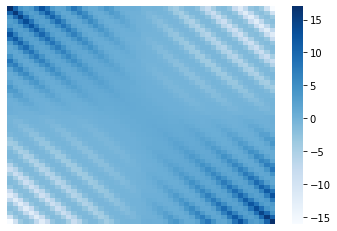

In [7]:
#COV = exponentiated_quadratic(X, X, length_scale=1)
COV = combo_kernel(X, X)
plt.figure()
sns.heatmap(COV, cmap='Blues', xticklabels=False, yticklabels=False)

Text(0, 0.5, '$f(x)$')

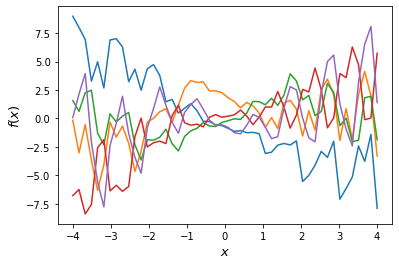

In [8]:
mean = np.zeros((COV.shape[0],))
x = np.random.multivariate_normal(mean.squeeze(), COV, size=num_samples)
for i in range(num_samples):
    plt.plot(X.squeeze(), x[i], '-')
plt.xlabel(r'$x$', fontsize=13)
plt.ylabel(r'$f(x)$', fontsize=13)

Text(0, 0.5, '$k(x_a,x_b)$')

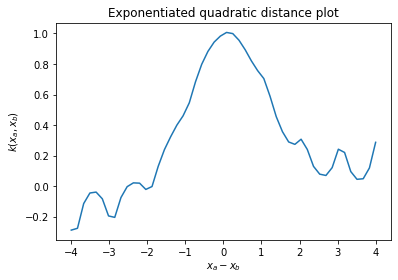

In [9]:
plt.plot(X, COV[25, :], '-', label=f'$l=${1}')
plt.title('Exponentiated quadratic distance plot')
plt.xlabel(r'$x_a-x_b$')
plt.ylabel(r'$k(x_a,x_b)$')

### Exercise

This exericse is mostly about familiarising yourself with the kernels
1. Using the kernel implementations and visualizations above, investigate the effect of changing the kernel parameters.
2. Define new kernels using kernel combinations (addition and multiplication). Explore the effect of different combinations and varying kernel parameters. 

## Part 2: Self study

In this exercise we will be experimenting with data on atmosoheric CO2 measurements data from Mauna Loa. You can find additional information about the data from the <a href="https://scrippsco2.ucsd.edu/data/atmospheric_co2/primary_mlo_co2_record.html">here</a>, included the full data set. In this exercise we will be using a slightly cleaned up version of the original dataset.

In [10]:
co2_df = pd.read_csv(
    # Source: https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/monthly/monthly_in_situ_co2_mlo.csv
    './co2.csv',
    header=0, # Data starts here
    usecols=[3, 4], # Only keep the 'Date' and 'CO2' columns
    na_values='-99.99',  # NaNs are denoted as '-99.99'
    dtype=np.float64,
    sep=','
)

In [11]:
# Drop missing values
co2_df.dropna(inplace=True)

In [12]:
# Split the data into an observed part and a part we want to make predictions for
date_split_predict = 2010
df_observed = co2_df[co2_df.Date < date_split_predict]
print('{} measurements in the observed set'.format(len(df_observed)))
df_predict = co2_df[co2_df.Date >= date_split_predict]
print('{} measurements in the test set'.format(len(df_predict)))

617 measurements in the observed set
154 measurements in the test set


Text(0.5, 1.0, 'In situ air measurements at Mauna Loa, Observatory, Hawaii')

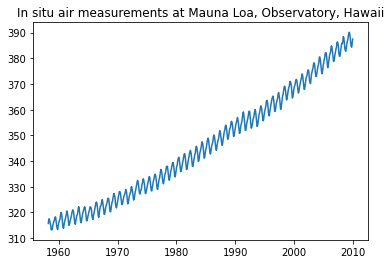

In [13]:
plt.figure()
plt.plot(df_observed.iloc[:,0].values, df_observed.iloc[:,1].values)
plt.title("In situ air measurements at Mauna Loa, Observatory, Hawaii")

Separate out the input data and the observations

In [14]:
x_train = df_observed['Date'].values
f_train = df_observed['CO2'].values
x_test = df_predict['Date'].values
f_test = df_predict['CO2'].values

Setup a first shot at a kernel. Scikit learn offers a variety of predifed kernels. An overview of the available kernels can be found <a href="https://scikit-learn.org/stable/modules/gaussian_process.html#kernels-for-gaussian-processes">here</a> and a gentle introduction to Gaussian processes in sklearn can be found <a href="https://scikit-learn.org/stable/modules/gaussian_process.html#">here</a>. In particular, it would be a good idea to consult the kernel section to get a better understanding of the kernel specification below.

In [15]:
co2_kernel = 50**2*RBF(length_scale=20) + WhiteKernel(noise_level=5.4, noise_level_bounds="fixed") + (ExpSineSquared(length_scale=1, periodicity=1))

With the kernel specified, we can start a Gaussian process model of our training data. 

In [16]:
f_mean = f_train.mean()
gaussian_process = GaussianProcessRegressor(kernel=co2_kernel, normalize_y=False)
gaussian_process.fit(x_train.reshape(-1,1), f_train - f_mean)

GaussianProcessRegressor(kernel=50**2 * RBF(length_scale=20) + WhiteKernel(noise_level=5.4) + ExpSineSquared(length_scale=1, periodicity=1))

Using our newly learned GP, we can do prediction on the test data.

In [17]:
mean_f_pred, std_f_pred = gaussian_process.predict(x_test.reshape(-1,1), return_std=True)
mean_f_pred += f_mean

Let's get a feel for the results

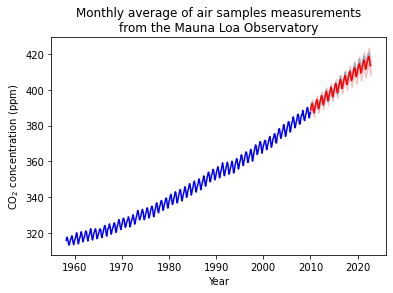

In [21]:
plt.plot(x_train, f_train, '-b')
plt.plot(x_test, f_test, color="tab:blue", alpha=0.4)
plt.plot(x_test, mean_f_pred, '-r')
plt.fill_between(
    x_test.ravel(),
    mean_f_pred - std_f_pred,
    mean_f_pred + std_f_pred,
    color="tab:red",
    alpha=0.2,
)
plt.xlabel("Year")
plt.ylabel("CO$_2$ concentration (ppm)")
_ = plt.title(
    "Monthly average of air samples measurements\nfrom the Mauna Loa Observatory")
plt.show()


Kernel parameters:

In [19]:
gaussian_process.kernel_

47.4**2 * RBF(length_scale=28.4) + WhiteKernel(noise_level=5.4) + ExpSineSquared(length_scale=0.881, periodicity=1)

In [20]:
print(f"RMSE: {np.mean((mean_f_pred - f_test)**2)}")

RMSE: 1.4653615442332992


### Exercise

Our Gaussian process model does clearly not do a good job at capturing the evolution in the CO2 measurements. For one thing, it completely ignores the periodicity in the signal.
1. Construct a new kernel that better captures the CO2 measurements in the test set
2. Use your Gaussian process model to estimate the missing CO2 mesurement values in the dat set. 